<a href="https://colab.research.google.com/github/pirisc/portfolio/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Computer Vision Libraries

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib
import matplotlib.pyplot as plt

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting the dataset

We are going to use the FashionMNIST dataset - consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

More info about the dataset: https://github.com/zalandoresearch/fashion-mnist



In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [ ]:
# See first training sample
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [ ]:
# What is the shape of our images?
print(f"Image size: {image.shape} -> [color_channels, height, width]")

Image size: torch.Size([1, 28, 28]) -> [color_channels, height, width]


In [ ]:
# How many examples do we have?
len(train_data.data), len(train_data.targets),len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [ ]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### 1.1 Visualizing our data

Image shape: torch.Size([1, 28, 28])


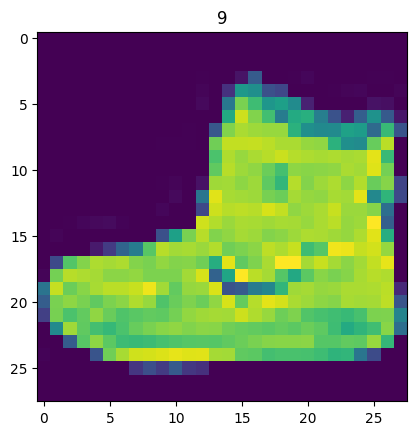

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label);

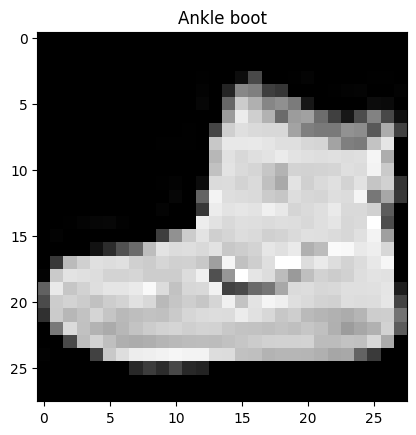

In [ ]:
# Show the image into grayscale
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

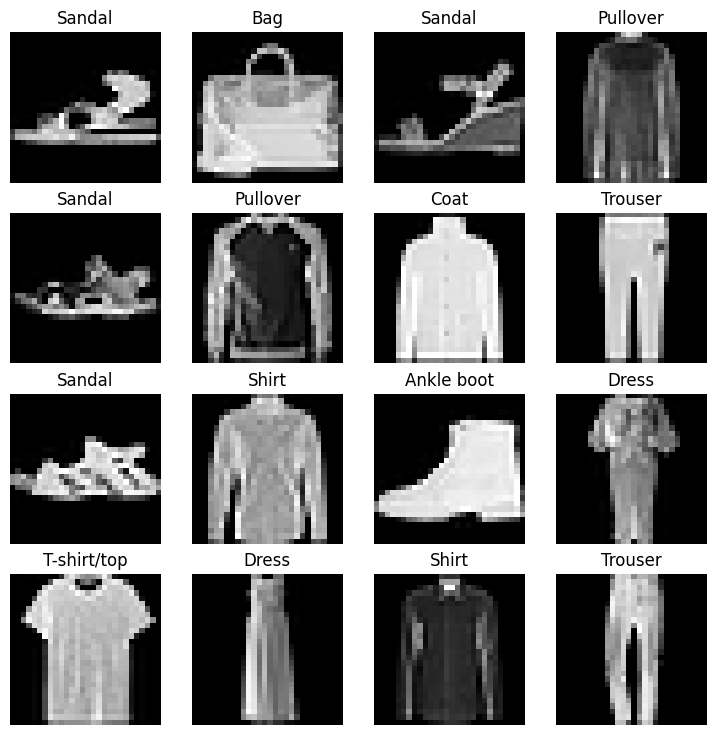

In [ ]:
# Plot more images
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols +1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img,label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

## 2. Prepare DataLoader

In [ ]:
from torch.utils.data import DataLoader

# Setup batch size
BATCH_SIZE = 32

# Create Dataloaders
train_dataloader = DataLoader(train_data,
                              BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             BATCH_SIZE,
                             shuffle=False)

# Print some info
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## 3. Model 0: Baseline model

In [ ]:
# Define the model
from torch import nn
class FashionMNISTV0(nn.Module):
  def __init__(self,
               input_shape: int = 784, # 28 height*28 width pixels
               hidden_units: int = 128, # whatever you want
               output_shape: int = len(class_names)):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(hidden_units, output_shape)
    )
  def forward(self,x):
    return self.layer_stack(x)

In [ ]:
# Setup model with parameters
model_0 = FashionMNISTV0(input_shape=784,
                         hidden_units=32 ,
                         output_shape = len(class_names)).to(device)
model_0

FashionMNISTV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [ ]:
8*40

320

### 3.1 Setup loss and optimizer

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

### 3.2 Train the baseline model

In [ ]:
from going_modular.going_modular import engine

set_seeds()

# Train and calculate results
model_0_results = engine.train(model_0,
                               train_dataloader,
                               test_dataloader,
                               optimizer,
                               loss_fn,
                               5,
                               device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5587 | train_acc: 0.8083 | test_loss: 0.4936 | test_acc: 0.8281
Epoch: 2 | train_loss: 0.4496 | train_acc: 0.8429 | test_loss: 0.4636 | test_acc: 0.8359
Epoch: 3 | train_loss: 0.4314 | train_acc: 0.8502 | test_loss: 0.4659 | test_acc: 0.8367
Epoch: 4 | train_loss: 0.4197 | train_acc: 0.8534 | test_loss: 0.4541 | test_acc: 0.8409
Epoch: 5 | train_loss: 0.4138 | train_acc: 0.8548 | test_loss: 0.4498 | test_acc: 0.8426


### 3.3 Plot loss curves

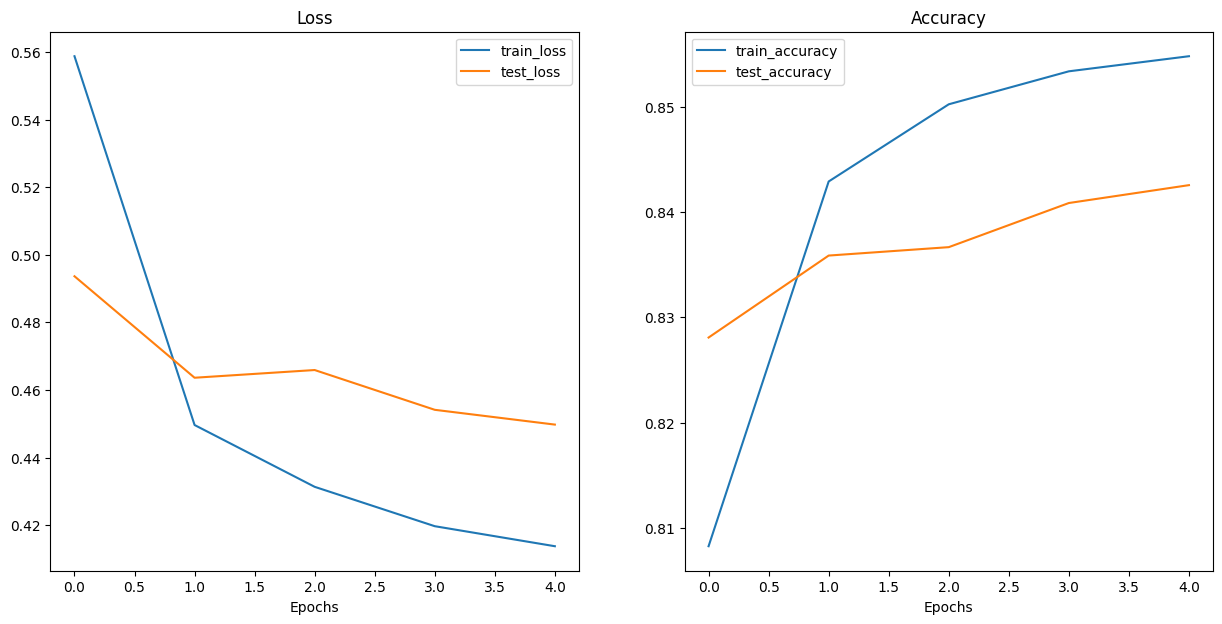

In [ ]:
# Plot loss curves
plot_loss_curves(model_0_results)

## 4. Model 1: Building a Convolutional Neural Network (CNN)

In [ ]:
# Create a convolutional neural network
class FashionMNISTV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride =2)
    )
    self.block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
          nn.Flatten(),
          # It's because each layer of our network compresses and changes the shape of our input data.
          nn.Linear(in_features=hidden_units*7*7,
                    out_features=output_shape)
    )

  def forward(self,x):
    return self.classifier(self.block_2(self.block_1(x)))

In [ ]:
model_1 = FashionMNISTV1(input_shape=1,
                         hidden_units = 64,
                         output_shape = len(class_names)).to(device)
model_1

FashionMNISTV1(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=10, bias=True)
  )
)

In [ ]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr = 0.001)

In [ ]:
from going_modular.going_modular import engine

set_seeds()

# Train and calculate results
model_1_results = engine.train(model_1,
                               train_dataloader,
                               test_dataloader,
                               optimizer,
                               loss_fn,
                               5,
                               device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3904 | train_acc: 0.8589 | test_loss: 0.2961 | test_acc: 0.8932
Epoch: 2 | train_loss: 0.2521 | train_acc: 0.9079 | test_loss: 0.2513 | test_acc: 0.9063
Epoch: 3 | train_loss: 0.2092 | train_acc: 0.9245 | test_loss: 0.2407 | test_acc: 0.9172
Epoch: 4 | train_loss: 0.1818 | train_acc: 0.9335 | test_loss: 0.2255 | test_acc: 0.9182
Epoch: 5 | train_loss: 0.1585 | train_acc: 0.9417 | test_loss: 0.2377 | test_acc: 0.9203


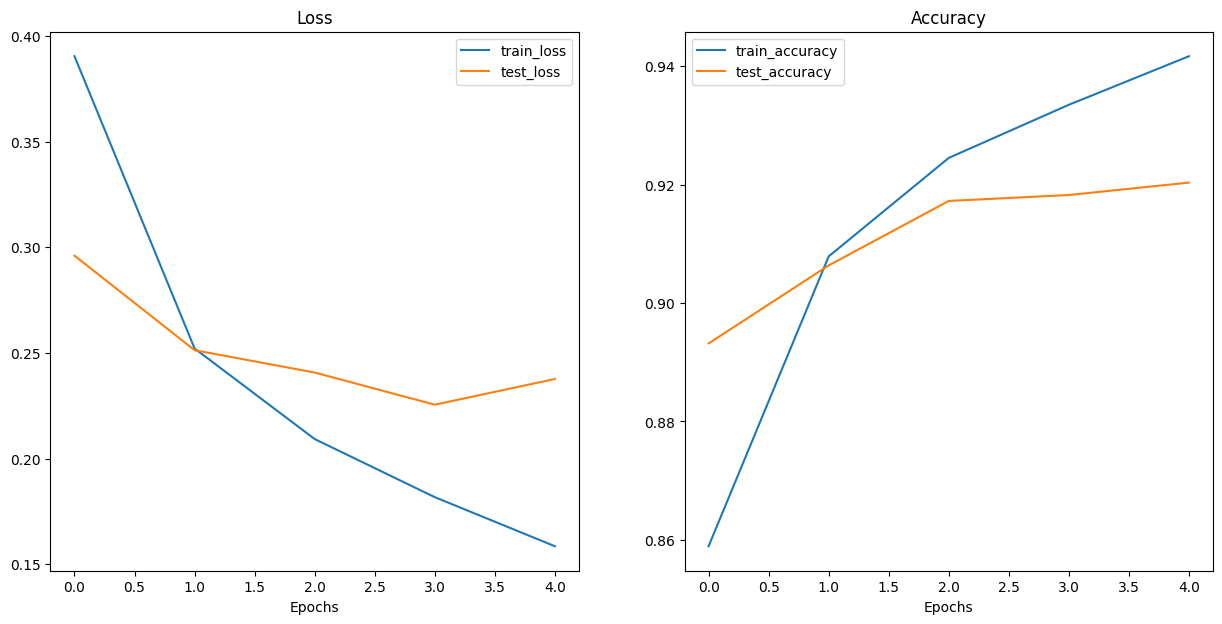

In [ ]:
# Plot loss curves
plot_loss_curves(model_1_results)

## 5. Model 2

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG but with a few changes
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # default stride value is same as kernel_size
            nn.Dropout(p=0.1)
            )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.1)
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features = hidden_units*3*3,
                      out_features = 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.block_3(x)
        x = self.classifier(x)
        # print(x.shape)
        return x


In [ ]:
model_2 = FashionMNISTModelV2(input_shape=1,
                       hidden_units = 64,
                       output_shape = len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(), lr = 0.001)

In [ ]:
# Train the model
from going_modular.going_modular import engine

# Calculate results
model_2_results = engine.train(model= model_2,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 10,
                               device = device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3794 | train_acc: 0.8604 | test_loss: 0.2699 | test_acc: 0.9002
Epoch: 2 | train_loss: 0.2545 | train_acc: 0.9070 | test_loss: 0.2271 | test_acc: 0.9182
Epoch: 3 | train_loss: 0.2220 | train_acc: 0.9192 | test_loss: 0.2233 | test_acc: 0.9209
Epoch: 4 | train_loss: 0.1965 | train_acc: 0.9279 | test_loss: 0.2369 | test_acc: 0.9170
Epoch: 5 | train_loss: 0.1780 | train_acc: 0.9349 | test_loss: 0.2040 | test_acc: 0.9279
Epoch: 6 | train_loss: 0.1638 | train_acc: 0.9396 | test_loss: 0.1956 | test_acc: 0.9268
Epoch: 7 | train_loss: 0.1485 | train_acc: 0.9450 | test_loss: 0.2038 | test_acc: 0.9294
Epoch: 8 | train_loss: 0.1399 | train_acc: 0.9474 | test_loss: 0.1968 | test_acc: 0.9367
Epoch: 9 | train_loss: 0.1284 | train_acc: 0.9524 | test_loss: 0.1996 | test_acc: 0.9345
Epoch: 10 | train_loss: 0.1173 | train_acc: 0.9548 | test_loss: 0.2020 | test_acc: 0.9331


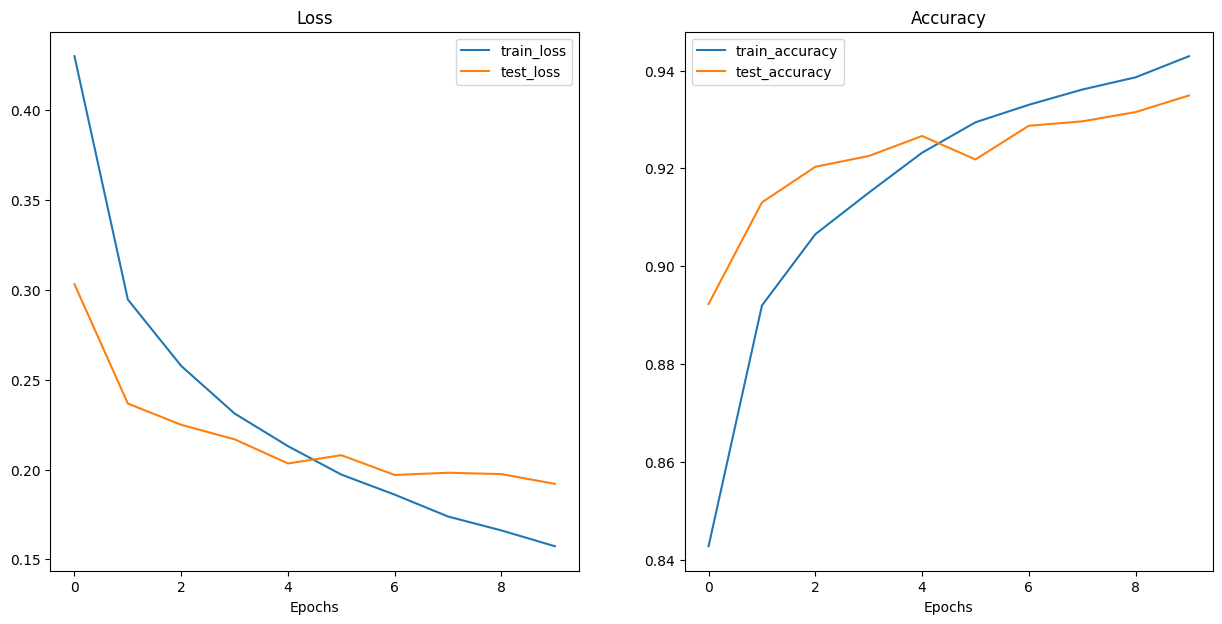

In [ ]:
plot_loss_curves(results = model_2_results)

In [ ]:
import torch
from torch import nn

class FashionMNISTModelV3(nn.Module):
    """
    An upgraded TinyVGG-style CNN with:
    - BatchNorm
    - Dropout
    - Dynamic Flattened Size
    - Optional AdaptiveAvgPool2d
    - Clean __repr__
    - Weight initialization
    """

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )

        self.flatten = nn.Flatten()
        self._to_linear = self._get_flattened_size((input_shape, 28, 28))  # for 28x28 input

        self.classifier = nn.Sequential(
            nn.Linear(in_features=self._to_linear, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128, out_features=output_shape)
        )

        self._init_weights()

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.block_1(x)
            x = self.block_2(x)
            x = self.flatten(x)
        return x.shape[1]

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def __repr__(self):
        return f"{self.__class__.__name__}(in_channels={self.block_1[0].in_channels}, out_classes={self.classifier[-1].out_features})"


In [ ]:
model_3 = FashionMNISTModelV2(input_shape=1,
                       hidden_units = 64,
                       output_shape = len(class_names)).to(device)
model_3

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_3.parameters(), lr = 0.001)

In [ ]:
# Train the model
from going_modular.going_modular import engine

# Calculate results
model_3_results = engine.train(model= model_3,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 5,
                               device = device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4287 | train_acc: 0.8458 | test_loss: 0.3049 | test_acc: 0.8885
Epoch: 2 | train_loss: 0.2956 | train_acc: 0.8942 | test_loss: 0.2572 | test_acc: 0.9070
Epoch: 3 | train_loss: 0.2579 | train_acc: 0.9069 | test_loss: 0.2284 | test_acc: 0.9148
Epoch: 4 | train_loss: 0.2303 | train_acc: 0.9171 | test_loss: 0.2219 | test_acc: 0.9182
Epoch: 5 | train_loss: 0.2154 | train_acc: 0.9226 | test_loss: 0.2147 | test_acc: 0.9250


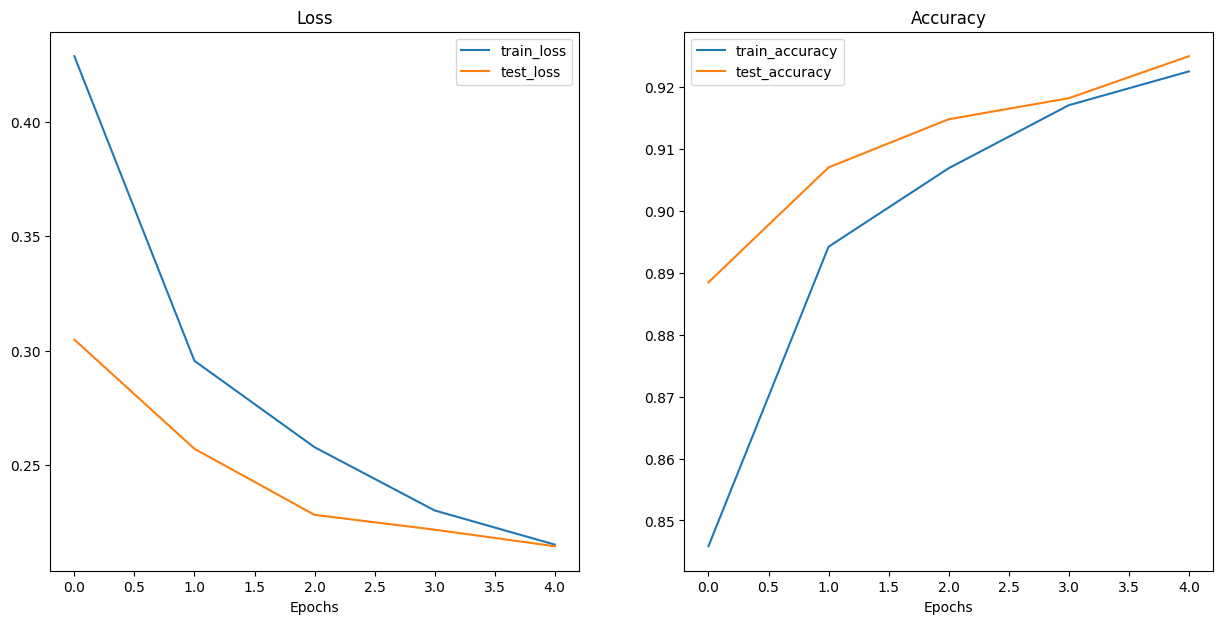

In [ ]:
plot_loss_curves(model_3_results)

In [ ]:
from torchvision import transforms

# Get pretrained weights and transforms
weights = torchvision.models.mobilenet_v2.DEFAULT

auto_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
# Load the data with the correspondent transforms
train_dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=auto_transform)
test_dataset = datasets.FashionMNIST(root="data", train=False, download=True, transform=auto_transform)

In [ ]:
# Create dataloaders
train_dataloader_pretrained = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 2, pin_memory = True)
test_dataloader_pretrained = DataLoader(test_dataset, batch_size= 64, shuffle = False, num_workers = 2, pin_memory = True)


In [ ]:
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
# Load the model
pretrained_model = torchvision.models.resnet18(weights=weights)
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Freeze layers
for param in pretrained_model.parameters():
  param.requires_grad = False

In [ ]:
# Replace the classifier for the 10MNIST classes
pretrained_model.fc = nn.Linear(in_features = 512, out_features = len(class_names))
pretrained_model = pretrained_model.to(device)

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.fc.parameters(), lr=0.001)

In [ ]:
# Train the model
set_seeds()
results_pretrained_model = engine.train(model=pretrained_model,
                                        train_dataloader = train_dataloader_pretrained,
                                        test_dataloader = test_dataloader_pretrained,
                                        optimizer = optimizer,
                                        loss_fn = loss_fn,
                                        epochs = 5,
                                        device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7440 | train_acc: 0.7529 | test_loss: 0.5970 | test_acc: 0.7978
Epoch: 2 | train_loss: 0.6008 | train_acc: 0.7929 | test_loss: 0.5861 | test_acc: 0.8001
Epoch: 3 | train_loss: 0.5809 | train_acc: 0.7971 | test_loss: 0.5720 | test_acc: 0.8046
Epoch: 4 | train_loss: 0.5742 | train_acc: 0.7996 | test_loss: 0.5744 | test_acc: 0.8021
Epoch: 5 | train_loss: 0.5649 | train_acc: 0.8026 | test_loss: 0.5674 | test_acc: 0.8059
